# Canonical NICE learns a toy 2D dataset
Refs: 1705.07057, 
https://github.com/ericjang/normalizing-flows-tutorial/blob/master/nf_part1_intro.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
layers = tf.contrib.layers

In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'batchSize': 1024,
    'numBijectors': 4,
    'trainIters': 1e5}

## 1. Collect data
Sample from distrution 
p(x1,x2) = N(x2|0,4) N(x1|1/4 x2^2 , 1)
where N is Gaussian

(-10, 10)

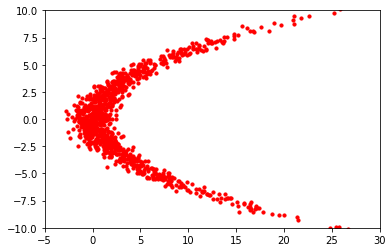

In [5]:
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(settings['batchSize'])
# Define a batch of scalar valued Normals. 
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples), scale=tf.ones(settings['batchSize'], dtype=DTYPE))
# Get 1 sample, returning a vector of size batch_size.
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)
# Evaluate graph and get ndarray
np_samples = sess.run(x_samples)
# Plot
plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
plt.xlim([-5, 30])
plt.ylim([-10, 10])

## 2. Construct flow
Use https://www.tensorflow.org/api_docs/python/tf/contrib/distributions/bijectors/Bijector

In [6]:
###################
# Signed exchange #
###################
class CanonicalSignedExchange(tfb.Bijector):
    """Canonical signed exchange:
    Q = p 
    P = - q
    """

    def __init__(self, n, layer_id=0, validate_args=False, name="CanonicalSignedExchange"):
        """
        Args:
          n: 1/2 dimensionality of phase space
        """
        # forward_min_event_ndims is the minimum number of dimensions for which
        # transformation makes sense. Here 1: vector
        super(CanonicalSignedExchange, self).__init__(
            is_constant_jacobian=True,  # Use result of first call for all data points for efficiency
            forward_min_event_ndims=1,  # forward_min_event_ndims is the minimum number of dimensions for which
                                        # transformation makes sense. Here 1: vector
            validate_args=validate_args, 
            name=name)
        self.n = n
        self.id = layer_id

    def _forward(self, x):
        # Forward. x is [batch_dim, 2*self.n]
        assert(x.shape[1] == 2*self.n)
        q, p = x[:, :self.n], x[:, self.n:]
        Q = p
        P = -q
        return tf.concat([Q, P], axis=1)

    def _inverse(self, y):
        # Inverse. y is [batch_dim, 2*self.n]
        assert(y.shape[1] == 2*self.n)
        Q, P = y[:, :self.n], y[:, self.n:]
        q = -P
        p = Q
        return tf.concat([q, p], axis=1)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(0., dtype=y.dtype, name="ildj")

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., dtype=x.dtype, name="fldj")

###############
# Nice Type 1 #
###############
def net1(x, out_size):
    # stack of 3 fc layers with input x. Non-linearity relu (default)
    return layers.stack(x, layers.fully_connected, [512, 512, out_size])
    
class CanonicalNiceType1(tfb.Bijector):
    """Nice bijector for type 1 canonical transformations:
    Q = p - f(q)
    P = - q
    """

    def __init__(self, n, layer_id=0, validate_args=False, name="CanonicalNiceType1"):
        """
        Args:
          n: 1/2 dimensionality of phase space
        """
        # forward_min_event_ndims is the minimum number of dimensions for which
        # transformation makes sense. Here 1: vector
        super(CanonicalNiceType1, self).__init__(
            is_constant_jacobian=True,  # Use result of first call for all data points for efficiency
            forward_min_event_ndims=1,  # forward_min_event_ndims is the minimum number of dimensions for which
                                        # transformation makes sense. Here 1: vector
            validate_args=validate_args, 
            name=name)
        self.n = n
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.n])
        self.f(tmp)

    def f(self, x):
        # Call the neural network. x is a vector of dimension self.n
        with tf.variable_scope('f%d' % self.id, reuse=tf.AUTO_REUSE):
            return net1(x, self.n)

    def _forward(self, x):
        # Forward. x is [batch_dim, 2*self.n]
        assert(x.shape[1] == 2*self.n)
        q, p = x[:, :self.n], x[:, self.n:]
        Q = p - self.f(q)
        P = -q
        return tf.concat([Q, P], axis=1)

    def _inverse(self, y):
        # Inverse. y is [batch_dim, 2*self.n]
        assert(y.shape[1] == 2*self.n)
        Q, P = y[:, :self.n], y[:, self.n:]
        q = -P
        p = Q + self.f(-P)
        return tf.concat([q, p], axis=1)

    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
        # The full log jacobian determinant would be array_ops.zero_like(x).
        # However, we circumvent materializing that, since the jacobian
        # calculation is input independent, and we specify it for one input.
        return tf.constant(0., x.dtype.base_dtype)

###############
# Nice Type 2 #
###############
def net2(x, out_size):
    # stack of 3 fc layers with input x. Non-linearity relu (default)
    return layers.stack(x, layers.fully_connected, [512, 512, out_size])
    
class CanonicalNiceType2(tfb.Bijector):
    """Nice bijector for type 2 canonical transformations:
    Q = q
    P = p - f(q)
    """

    def __init__(self, n, layer_id=0, validate_args=False, name="CanonicalNiceType2"):
        """
        Args:
          n: 1/2 dimensionality of phase space
        """
        # forward_min_event_ndims is the minimum number of dimensions for which
        # transformation makes sense. Here 1: vector
        super(CanonicalNiceType2, self).__init__(
            is_constant_jacobian=True,  # Use result of first call for all data points for efficiency
            forward_min_event_ndims=1,  # forward_min_event_ndims is the minimum number of dimensions for which
                                        # transformation makes sense. Here 1: vector  
            validate_args=validate_args, 
            name=name)
        self.n = n
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.n])
        self.f(tmp)

    def f(self, x):
        # Call the neural network. x is a vector of dimension self.n
        with tf.variable_scope('f%d' % self.id, reuse=tf.AUTO_REUSE):
            return net2(x, self.n)

    def _forward(self, x):
        # Forward. x is [batch_dim, 2*self.n]
        assert(x.shape[1] == 2*self.n)
        q, p = x[:, :self.n], x[:, self.n:]
        Q = q
        P = p - self.f(q)
        return tf.concat([Q, P], axis=1)

    def _inverse(self, y):
        # Inverse. y is [batch_dim, 2*self.n]
        assert(y.shape[1] == 2*self.n)
        Q, P = y[:, :self.n], y[:, self.n:]
        q = Q
        p = P + self.f(Q)
        return tf.concat([q, p], axis=1)

    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
        # The full log jacobian determinant would be array_ops.zero_like(x).
        # However, we circumvent materializing that, since the jacobian
        # calculation is input independent, and we specify it for one input.
        return tf.constant(0., x.dtype.base_dtype)

###############
# Nice Type 4 #
###############
def net4(x, out_size):
    # stack of 3 fc layers with input x. Non-linearity relu (default)
    return layers.stack(x, layers.fully_connected, [512, 512, out_size])
    
class CanonicalNiceType4(tfb.Bijector):
    """Nice bijector for type 2 canonical transformations:
    Q = p
    P = - p - f(p)
    """

    def __init__(self, n, layer_id=0, validate_args=False, name="CanonicalNiceType4"):
        """
        Args:
          n: 1/2 dimensionality of phase space
        """
        # forward_min_event_ndims is the minimum number of dimensions for which
        # transformation makes sense. Here 1: vector
        super(CanonicalNiceType4, self).__init__(
            is_constant_jacobian=True,  # Use result of first call for all data points for efficiency
            forward_min_event_ndims=1,  # forward_min_event_ndims is the minimum number of dimensions for which
                                        # transformation makes sense. Here 1: vector  
            validate_args=validate_args, 
            name=name)
        self.n = n
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.n])
        self.f(tmp)

    def f(self, x):
        # Call the neural network. x is a vector of dimension self.n
        with tf.variable_scope('f%d' % self.id, reuse=tf.AUTO_REUSE):
            return net4(x, self.n)

    def _forward(self, x):
        # Forward. x is [batch_dim, 2*self.n]
        assert(x.shape[1] == 2*self.n)
        q, p = x[:, :self.n], x[:, self.n:]
        Q = p
        P = - q - self.f(p)
        return tf.concat([Q, P], axis=1)

    def _inverse(self, y):
        # Inverse. y is [batch_dim, 2*self.n]
        assert(y.shape[1] == 2*self.n)
        Q, P = y[:, :self.n], y[:, self.n:]
        q = - P - self.f(Q)
        p = Q
        return tf.concat([q, p], axis=1)

    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
        # The full log jacobian determinant would be array_ops.zero_like(x).
        # However, we circumvent materializing that, since the jacobian
        # calculation is input independent, and we specify it for one input.
        return tf.constant(0., x.dtype.base_dtype)

In [7]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [8]:
bijectors = []
for i in range(settings['numBijectors']):
    #bijectors.append(CanonicalNiceType1(n = 1, layer_id = i))
    # NICE as CanonicalType2:
    bijectors.append(tfb.RealNVP(
        num_masked=1,
        is_constant_jacobian=True,
        name="NICE",
        shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[512, 512],shift_only=True))) # MLP
    # signed exchange of coordinates 
    bijectors.append(CanonicalSignedExchange(n = 1, layer_id = i))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
#flow_bijector = tfb.Chain(list(reversed(bijectors)))

In [9]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

## 3. Visualize before training

In [10]:
# visualization (use batchSize samples)
x = base_dist.sample(settings['batchSize'])
samples = [x]
names = [base_dist.name]
# Need to reverse since list is inverted order
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [11]:
sess.run(tf.global_variables_initializer())

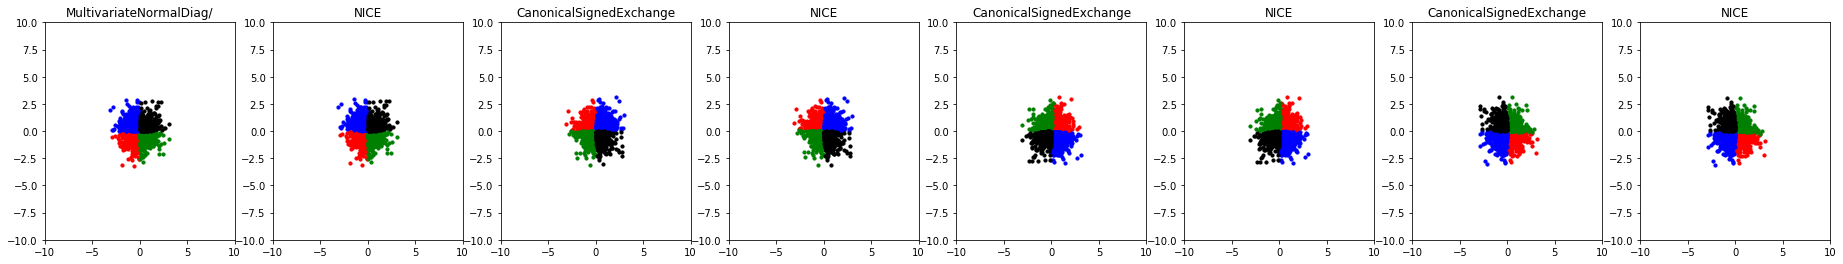

In [12]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

## 4. Optimize flow

In [13]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [14]:
sess.run(tf.global_variables_initializer())

0 35.415146
10000 5.584731
20000 5.8431864
30000 5.7984705
40000 5.787294
50000 5.9562607
60000 5.8588943
70000 5.8984003
80000 5.714406
90000 5.863967


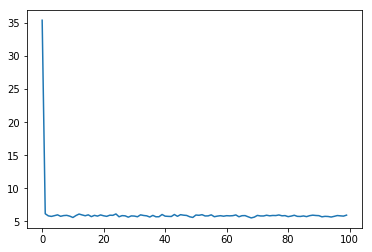

In [15]:
global_step = []
np_losses = []
for i in range(int(settings['trainIters'])):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

## 5. Visualize after training

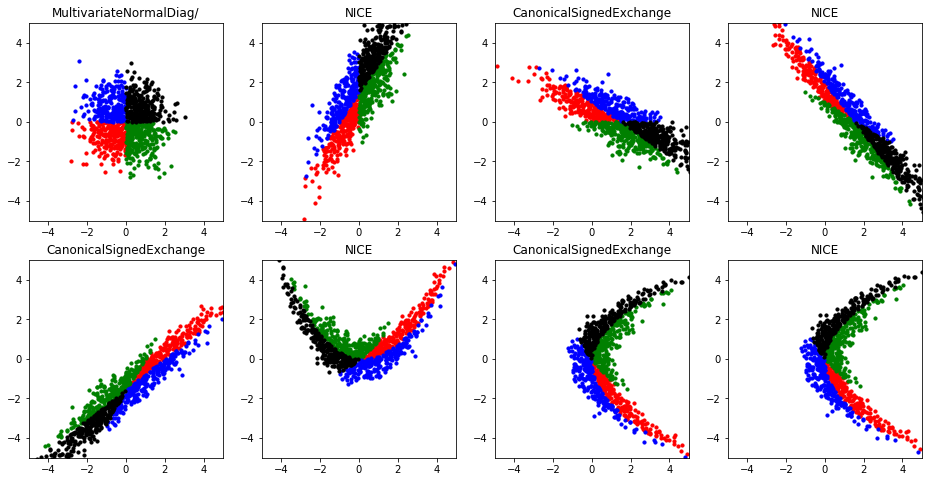

In [16]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('example_2D_CanonicalNICE_learned.png', dpi=300)

Push back the X samples to get the base distribution. Good fit means Gaussian.

In [17]:
z = dist.bijector.inverse(x_samples)
result = sess.run(z)

(-10, 10)

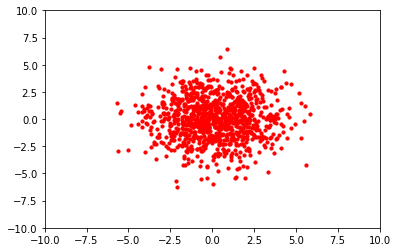

In [18]:
# Plot
plt.scatter(result[:, 0], result[:, 1], s=10, color='red')
plt.xlim([-10,10])
plt.ylim([-10,10])